C:\Users\wkdgm\anaconda3\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1024
  warnings.warn(
C:\Users\wkdgm\anaconda3\lib\site-packages\librosa\core\spectrum.py:1641: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn(


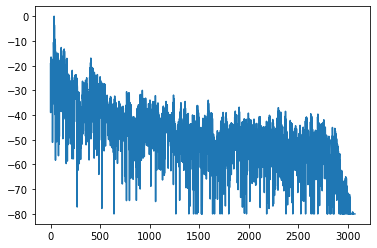

In [7]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

audio_file = './sample.wav'
y, sr = librosa.load(audio_file)

D = librosa.amplitude_to_db(librosa.stft(y[:1024]), ref=np.max)
 
plt.plot(D.flatten())
plt.show()

In [1]:
import pyaudio
from six.moves import queue
import time

# 녹음용 값 
# 16khz
RATE = 16000
# 버퍼는 1600
CHUNK = int(RATE / 10)  # 100ms

In [2]:
class MicrophoneStream(object):
    """마이크 입력 클래스"""
    def __init__(self, rate, chunk):
        self._rate = rate
        self._chunk = chunk

        # 마이크 입력 버퍼 생성
        self._buff = queue.Queue()
        self.closed = True

    # 클래스 열면 발생함.
    def __enter__(self):
        # pyaudio 인터페이스 생성
        self._audio_interface = pyaudio.PyAudio()
        # 16비트, 모노로 마이크 열기
        # 여기서 _fill_buffer 함수가 바로 callback함수 인데
        # 실제 버퍼가 쌓이면 이곳이 호출된다.
        # 즉, _fill_buffer 마이크 입력을 _fill_buffer 콜백함수로 전달 받음
        self._audio_stream = self._audio_interface.open(
            format=pyaudio.paInt16,
            channels=1, rate=self._rate,
            input=True, frames_per_buffer=self._chunk,
            stream_callback=self._fill_buffer,
        )        
        self.closed = False
        return self

    def __exit__(self, type, value, traceback):
        # 클래스 종료시 발생
        # pyaudio 종료
        self._audio_stream.stop_stream()
        self._audio_stream.close()

        self.closed = True
        # Signal the generator to terminate so that the client's
        # streaming_recognize method will not block the process termination.
        self._buff.put(None)
        self._audio_interface.terminate()
    
    # 마이크 버퍼가 쌓이면(CHUNK = 1600) 이 함수 호출 됨. 
    def _fill_buffer(self, in_data, frame_count, time_info, status_flags):
        # 마이크 입력 받으면 큐에 넣고 리턴
        self._buff.put(in_data)
        return None, pyaudio.paContinue

    # 제너레이터 함수 
    def generator(self):
        #클래스 종료될 떄까지 무한 루프 돌림 
        while not self.closed:
            
            # 큐에 데이터를 기다림.
            # block 상태임.
            chunk = self._buff.get()

            # 데이터가 없다면 문제 있음
            if chunk is None:
                return

            # data에 마이크 입력 받기
            data = [chunk]

            # 추가로 받을 마이크 데이터가 있는지 체크 
            while True:
                try:
                    # 데이터가 더 있는지 체크
                    chunk = self._buff.get(block=False)
                    if chunk is None:
                        return
                    # 데이터 추가
                    data.append(chunk)
                except queue.Empty:
                    # 큐에 데이터가 더이상 없다면 break
                    break

            #마이크 데이터를 리턴해줌 
            yield b''.join(data)
# [END audio_stream]

In [3]:
def main():
    # 마이크 열기 
    with MicrophoneStream(RATE, CHUNK) as stream:
        # 마이크 데이터 핸들을 가져옴 
        audio_generator = stream.generator()
        for i in range(1000):
            # 1000번만 마이크 데이터 가져오고 빠져나감.

            for x in audio_generator:
                # 마이크 음성 데이터
                print(x)            
            time.sleep(0.001)

if __name__ == '__main__':
    main()

b'\xbe\x00C\x01\x00\x01\x17\x01\x1d\x01$\x01\x17\x01\x12\x01\x1a\x01\'\x01\x17\x01\x0e\x01\x10\x01\x1c\x01\x0b\x01\x11\x01!\x01\x17\x01\x08\x01\x16\x01\x19\x01\x17\x01\x0c\x01\x18\x01\x1b\x01\xfb\x00\x01\x01\x0f\x01\x14\x01\n\x01\x15\x01\x19\x01\x12\x01\x15\x01\x12\x01 \x01$\x01/\x01\x1d\x01 \x01+\x01/\x014\x01.\x01?\x01(\x01,\x018\x01.\x01!\x01,\x01<\x01A\x01:\x010\x012\x01A\x01@\x016\x01;\x01<\x013\x01.\x01=\x01<\x01/\x01:\x01<\x013\x01>\x01I\x01Q\x01I\x01-\x016\x01J\x014\x01-\x019\x01F\x01-\x01&\x01B\x01;\x014\x01;\x01B\x01E\x01C\x018\x01:\x016\x011\x018\x017\x01!\x01-\x01<\x019\x01(\x014\x01A\x01%\x01+\x018\x019\x01(\x010\x016\x01%\x01*\x01,\x01)\x010\x01.\x01)\x01"\x01%\x01.\x01#\x01\x1f\x01$\x01\x1f\x01.\x01/\x01\x1f\x010\x010\x011\x01*\x013\x018\x01E\x01B\x01,\x01?\x01A\x01.\x013\x01@\x01\x1b\x01&\x01C\x01.\x01%\x01"\x01\x1d\x01"\x01 \x01-\x01&\x01\x19\x01 \x01#\x01"\x01\x0e\x01\x1f\x01\x1d\x01\x0e\x01,\x01\x1c\x01\x11\x01\x19\x01\x18\x01$\x01\x17\x01 \x01)\x01!\x01#\x01\x12\x01

b'T\x00S\x00T\x00Z\x00W\x00`\x00i\x00W\x00^\x00e\x00f\x00e\x00a\x00h\x00U\x00X\x00b\x00h\x00c\x00Z\x00g\x00`\x00_\x00j\x00c\x00]\x00a\x00a\x00R\x00\\\x00q\x00g\x00k\x00q\x00s\x00z\x00x\x00v\x00f\x00m\x00t\x00l\x00f\x00y\x00|\x00w\x00l\x00y\x00v\x00s\x00\x84\x00y\x00q\x00~\x00\x80\x00\x83\x00\x83\x00u\x00\x82\x00\x84\x00\x86\x00\x84\x00\x84\x00q\x00y\x00\x98\x00\x99\x00\x83\x00\x8a\x00\x99\x00\x8f\x00\x82\x00\x8d\x00\x83\x00\x81\x00\x8d\x00\x7f\x00\x7f\x00u\x00|\x00}\x00s\x00u\x00q\x00m\x00k\x00o\x00x\x00k\x00l\x00l\x00p\x00|\x00o\x00]\x00b\x00p\x00|\x00p\x00a\x00{\x00s\x00k\x00l\x00i\x00o\x00d\x00a\x00c\x00^\x00b\x00m\x00a\x00]\x00[\x00T\x00M\x00J\x00N\x00P\x00W\x00;\x00C\x00d\x00T\x00R\x00H\x00E\x00\\\x00[\x00Y\x00]\x00\\\x00[\x00[\x00E\x00T\x00R\x00B\x00E\x00N\x00L\x00=\x00D\x00F\x00T\x00K\x00:\x00J\x00A\x00-\x00<\x002\x004\x003\x00<\x00H\x00<\x00:\x00R\x00G\x00K\x00C\x00@\x00S\x00I\x00K\x00M\x00K\x00C\x00G\x00I\x007\x006\x00A\x00A\x00K\x004\x00:\x004\x00>\x00>\x00 \x00\'\x00\'\x00,\

b'\xd5\xff\xe7\xff\xe1\xff\xdb\xff\xda\xff\xd7\xff\xd8\xff\xdd\xff\xd4\xff\xe0\xff\xec\xff\xdc\xff\xe4\xff\xe7\xff\xe6\xff\xe7\xff\xdc\xff\xea\xff\xe5\xff\xe7\xff\xf5\xff\xe5\xff\xe3\xff\xe4\xff\xe2\xff\xde\xff\xdb\xff\xd4\xff\xe0\xff\xdc\xff\xd4\xff\xda\xff\xd8\xff\xd6\xff\xce\xff\xd1\xff\xd7\xff\xc7\xff\xc6\xff\xd3\xff\xd2\xff\xd0\xff\xce\xff\xdb\xff\xe4\xff\xe3\xff\xe3\xff\xe3\xff\xe0\xff\xdd\xff\xe1\xff\xe2\xff\xd6\xff\xdc\xff\xd9\xff\xd5\xff\xd4\xff\xd8\xff\xea\xff\xe4\xff\xcb\xff\xd6\xff\xe3\xff\xcb\xff\xce\xff\xd1\xff\xd4\xff\xd9\xff\xda\xff\xcc\xff\xd9\xff\xe8\xff\xcf\xff\xcf\xff\xcf\xff\xdf\xff\xdc\xff\xcb\xff\xcc\xff\xc9\xff\xca\xff\xcf\xff\xd3\xff\xcf\xff\xc0\xff\xd1\xff\xce\xff\xce\xff\xd0\xff\xc2\xff\xd5\xff\xe7\xff\xe4\xff\xd4\xff\xd6\xff\xe0\xff\xe3\xff\xdc\xff\xd7\xff\xd2\xff\xd1\xff\xda\xff\xcc\xff\xc8\xff\xd0\xff\xd3\xff\xcf\xff\xd2\xff\xd4\xff\xd5\xff\xd6\xff\xd1\xff\xde\xff\xdd\xff\xdc\xff\xda\xff\xda\xff\xd4\xff\xde\xff\xd2\xff\xcc\xff\xce\xff\xbf\xff\xd0\xff\xd2\x

b'\xc2\xff\xe0\xff\xe8\xff\xd1\xff\xf6\xff\xe9\xff\xea\xff\xe1\xff\xee\xff\xe9\xff\xf7\xff\xf2\xff\xf7\xff\x0c\x00\xf3\xff\x0b\x00\x12\x00\xf4\xff\x07\x00\x00\x00\x05\x00\x05\x00\x14\x00\x1b\x00\x02\x00\xfe\xff\xf9\xff\xef\xff\xfa\xff\xef\xff\xfc\xff\x0c\x00\xe2\xff\x06\x00\x0c\x00\xed\xff\xf0\xff\xea\xff\x07\x00\xfa\xff\xf3\xff\xfc\xff\xe4\xff\xf5\xff\xf3\xff\xf5\xff\xf7\xff\xef\xff\x00\x00\xf6\xff\xf2\xff\xf8\xff\x03\x00\xec\xff\xf7\xff\x01\x00\xfb\xff\xfc\xff\xf6\xff\xef\xff\xf7\xff\x07\x00\xf6\xff\xfb\xff\xf1\xff\x04\x00\xf6\xff\x01\x00\xf6\xff\x08\x00\x14\x00\xef\xff\xf9\xff\xe4\xff\xe7\xff\xf9\xff\xf4\xff\xf7\xff\xf9\xff\xf3\xff\xfc\xff\xf9\xff\xee\xff\xf2\xff\xe5\xff\xe9\xff\xf5\xff\x01\x00\x0b\x00\xef\xff\xf3\xff\x08\x00\xfe\xff\x06\x00\xff\xff\xfd\xff\t\x00\xff\xff\r\x00\x0e\x00\x01\x00\xfb\xff\x00\x00\xfd\xff\x02\x00\xfb\xff\x02\x00\xec\xff\xfb\xff\xff\xff\xfc\xff\x01\x00\xf2\xff\t\x00\x06\x00\x16\x00\x0b\x00\x0b\x00\x15\x00\x10\x00\x10\x00\x12\x00\x06\x00\xff\xff\x04\x00\xf8

b'@\x00E\x00E\x00A\x00G\x005\x009\x00Q\x00N\x00<\x004\x00A\x00F\x00E\x00K\x00P\x00X\x00]\x00I\x00A\x00@\x00=\x00C\x00I\x00N\x00I\x00I\x00C\x00J\x00F\x00>\x00C\x00J\x00@\x00Q\x00D\x00:\x00A\x00E\x00O\x00B\x00H\x00N\x00@\x002\x00C\x00>\x007\x003\x009\x00A\x00A\x00C\x008\x006\x001\x00-\x002\x008\x001\x00-\x00:\x00/\x000\x00;\x006\x00/\x00/\x00@\x00:\x007\x00:\x00?\x00=\x005\x00E\x00N\x00E\x00=\x00B\x00G\x00H\x00?\x00M\x00M\x00K\x00S\x00J\x00I\x00C\x00L\x00L\x00I\x00H\x00A\x00R\x00[\x00[\x00E\x008\x00M\x00H\x00K\x00:\x00,\x00:\x00=\x00<\x00<\x003\x005\x00/\x000\x005\x00\'\x00/\x000\x002\x003\x000\x00/\x00/\x00\'\x00(\x00+\x00-\x00/\x00#\x004\x00@\x00/\x00-\x00<\x009\x00>\x00A\x00A\x00>\x007\x003\x00D\x00F\x009\x00.\x00,\x00#\x00&\x002\x00+\x00/\x000\x00*\x00-\x004\x00%\x00(\x00)\x00.\x00\x13\x00\x13\x00\x1b\x00\x18\x00\x17\x00\n\x00\x1a\x00\x1c\x00\x16\x00\x12\x00\x10\x00\t\x00\x0b\x00\x10\x00\r\x00\x1d\x00"\x00\x08\x00\x12\x00\x17\x00\x08\x00\x0c\x00\x0b\x00\x0c\x00\x0f\x00\t\x00\t\x00\x0

b'\xfb\xff\xf8\xff\x08\x00\x12\x00\x04\x00\x0e\x00\x15\x00\xfe\xff\xfc\xff\x03\x00\xf5\xff\x02\x00\x07\x00\x04\x00\x0f\x00\x03\x00\x01\x00\x06\x00\x05\x00\xfc\xff\x0b\x00\x10\x00\xff\xff\x12\x00\x05\x00\x08\x00\x04\x00\xf3\xff\xfd\xff\x03\x00\xfb\xff\xfb\xff\x11\x00\x0b\x00\x0e\x00\x04\x00\x0c\x00\x02\x00\x02\x00\x11\x00\r\x00\x0e\x00\n\x00\x08\x00\x0c\x00\n\x00\x08\x00\x01\x00\x11\x00\x11\x00\x08\x00\x16\x00\x15\x00\x11\x00\x0b\x00\x0f\x00\x18\x00\x0b\x00\xfc\xff\x06\x00\n\x00\x02\x00\x05\x00\t\x00\x05\x00\n\x00\x07\x00\x01\x00\xfe\xff\xfb\xff\xf7\xff\x06\x00\xfc\xff\n\x00\x11\x00\xf6\xff\x00\x00\x0b\x00\xfc\xff\x07\x00\xfe\xff\xfc\xff\x05\x00\x0e\x00\x0c\x00\xf4\xff\xfc\xff\xf9\xff\xf4\xff\xff\xff\xff\xff\xfa\xff\xf9\xff\x00\x00\n\x00\x0e\x00\x05\x00\xfd\xff\x01\x00\r\x00\x0e\x00\x01\x00\x04\x00\x11\x00\x12\x00\x03\x00\x03\x00\x0b\x00\x0e\x00\x0b\x00\x08\x00\r\x00\x08\x00\n\x00\r\x00\x19\x00\x16\x00\x0b\x00\x04\x00\x0c\x00\t\x00\n\x00\x16\x00\x19\x00\r\x00\x03\x00\x06\x00\r\x00\x0e\x

b'\xe7\xff\xe2\xff\xe4\xff\xe0\xff\xdb\xff\xe5\xff\xe1\xff\xde\xff\xe3\xff\xdd\xff\xe0\xff\xe5\xff\xe8\xff\xe2\xff\xe8\xff\xec\xff\xf3\xff\xf0\xff\xf5\xff\xf2\xff\xdf\xff\xef\xff\xeb\xff\xe9\xff\xeb\xff\xee\xff\x02\x00\x06\x00\xfd\xff\xfd\xff\x00\x00\xfa\xff\xfd\xff\xf7\xff\xf8\xff\xfb\xff\xfe\xff\xf7\xff\xf8\xff\x0c\x00\x07\x00\t\x00\x02\x00\xfa\xff\xfa\xff\x03\x00\xfe\xff\xfe\xff\xfd\xff\xe4\xff\x00\x00\x0c\x00\xf8\xff\x03\x00\r\x00\n\x00\x02\x00\x03\x00\x07\x00\x08\x00\x12\x00\x0e\x00\x0f\x00\x12\x00\n\x00\x06\x00\x03\x00\x0e\x00\x0e\x00\x05\x00\x07\x00\t\x00\x0c\x00\x11\x00\x15\x00\x0f\x00\x15\x00\x0b\x00\x01\x00\xfe\xff\x08\x00\x05\x00\x07\x00\x17\x00\x10\x00\x0c\x00\x02\x00\x03\x00\x01\x00\xff\xff\xfc\xff\x02\x00\x08\x00\x04\x00\x06\x00\x00\x00\xff\xff\xff\xff\xfe\xff\x00\x00\x00\x00\xff\xff\n\x00\t\x00\xfa\xff\xf8\xff\xfe\xff\xfa\xff\xe9\xff\xed\xff\xf2\xff\xf7\xff\xee\xff\xe4\xff\xec\xff\xec\xff\xea\xff\xe5\xff\xe5\xff\xed\xff\xe8\xff\xe5\xff\xe9\xff\xe5\xff\xe6\xff\xe4\xff\xda

b'%\x002\x00;\x002\x00/\x005\x00\'\x00\'\x000\x00)\x00*\x00*\x00/\x00&\x00#\x00-\x00#\x00#\x00\x1d\x00$\x00&\x00\x19\x00"\x00*\x00&\x00*\x00#\x00 \x00\x1d\x00\x19\x00\x1f\x00\x1e\x00\x1c\x00\x1e\x00"\x00+\x005\x00(\x00 \x00-\x00(\x00!\x00-\x00*\x00)\x00#\x00"\x00 \x00\x1e\x00#\x00\x1a\x00\x19\x00\x12\x00\x11\x00\x1b\x00\x15\x00\x17\x00\x14\x00\x0c\x00\x0f\x00\x15\x00%\x00\x1b\x00\x16\x00\x11\x00\x0f\x00\x16\x00\x1e\x00\x1a\x00\x1d\x00\x18\x00\x0c\x00\x18\x00\x12\x00\x1c\x00+\x00\'\x00\x1b\x00(\x003\x00%\x00(\x00#\x00\x1f\x00#\x00\x1d\x00"\x00\x1f\x00\x1b\x00\x14\x00#\x00\'\x00\x17\x00 \x00\x1f\x00\x1b\x00\x18\x00\x1f\x00\x17\x00\x1c\x00-\x00&\x00$\x00\x1d\x00.\x00$\x00\x1d\x00\x1c\x00&\x00*\x00\x1b\x00\'\x00\x19\x00"\x00*\x00%\x00#\x00\x1f\x00\x1e\x00\x17\x00!\x00*\x00\x1c\x00#\x00\x1b\x00\x1c\x00#\x00\x1e\x00\x14\x00\r\x00\x11\x00\x17\x00\x19\x00 \x00!\x00\x1b\x00\x1b\x00\x15\x00\x17\x00"\x00\'\x00)\x00\'\x00 \x00*\x005\x00.\x00+\x00#\x00-\x00*\x00\x1a\x00&\x000\x00+\x00\x14\x00\x15\x

b'l\x00h\x00b\x00T\x00i\x00]\x00e\x00Z\x00W\x00S\x00Y\x00V\x00N\x00\\\x00E\x00U\x00I\x00C\x00L\x00M\x00C\x00<\x00:\x00H\x00P\x00?\x00G\x00P\x00C\x009\x008\x00@\x00P\x00J\x00L\x00G\x00C\x009\x007\x00>\x009\x005\x001\x009\x00-\x00+\x009\x00G\x00E\x00F\x00R\x002\x00C\x00=\x000\x00/\x00<\x00R\x00F\x00@\x00?\x00C\x00?\x008\x00G\x00C\x00:\x00:\x009\x00M\x008\x007\x006\x003\x00,\x003\x006\x00 \x00\x1f\x00\'\x00;\x00.\x00)\x00*\x00+\x00!\x00&\x009\x001\x00)\x00%\x001\x004\x00>\x00<\x00,\x003\x004\x00#\x00$\x00)\x00+\x00"\x001\x003\x00\x15\x00\'\x00+\x00)\x00\x1d\x00\x06\x00\x0e\x00\x1c\x00\x13\x00\x14\x00\x1c\x00\x06\x00\x1b\x00\x13\x00\x07\x00\x0c\x00\xff\xff\x08\x00\x14\x00\x1d\x00\x15\x00\t\x00\x02\x00\x17\x00\x1a\x00\x10\x00\x0f\x00\x18\x00\x18\x00\x15\x00 \x00\x13\x00\x04\x00\x01\x00\x08\x00\x18\x00\x15\x00\x0f\x00\x08\x00\x07\x00\x0e\x00\x01\x00\xf8\xff\x0b\x00\xfe\xff\xfa\xff\xfd\xff\xfc\xff\x01\x00\xfe\xff\xff\xff\xfb\xff\x0e\x00\xfd\xff\xf3\xff\x06\x00\x07\x00\x03\x00\xfc\xff\xf0\xff\

b'\x1a\x00\x0f\x00\x16\x00\x1f\x00+\x00\x1a\x00\x1c\x00\x18\x00#\x00\x1f\x00\x17\x00\x1c\x00\x0f\x00(\x00(\x00\x0f\x00\x19\x00*\x00\x13\x00\x1f\x00-\x00\x12\x00\x0e\x00\x16\x00%\x00\x18\x00\x1f\x00\x1f\x00\x1c\x00\x16\x00\'\x00\x15\x00\x11\x00)\x00\x1c\x00\x02\x00\x0f\x00-\x00\x0e\x00\x1d\x00!\x00\x17\x00*\x00/\x00\x19\x00\r\x00"\x00\x1f\x00-\x007\x00,\x00-\x003\x00N\x00T\x009\x00#\x00.\x000\x009\x001\x00(\x00-\x00\'\x002\x00)\x00&\x00)\x00-\x00\x0f\x00\x08\x00\x1a\x00\'\x007\x00\'\x00\x05\x00\n\x00-\x00/\x00\x0c\x00\x00\x00\x0b\x00\x11\x00"\x00\x19\x00\x0c\x00\x01\x00\x1c\x00+\x00\t\x00\xf1\xff\xf9\xff\n\x00\x0e\x00\x19\x00\x10\x00\x08\x00\x18\x00 \x00 \x00\x12\x00\x10\x00\x0e\x00\x0b\x00\x0b\x00\x03\x00\x04\x00\x12\x00\x11\x00\xf6\xff\x04\x00\xff\xff\x03\x00\x13\x00\x01\x00\xf3\xff\xfd\xff\xfa\xff\xff\xff\x07\x00\xf7\xff\xf6\xff\xfd\xff\r\x00\xf4\xff\xdc\xff\xdd\xff\xdc\xff\xf0\xff\xed\xff\xf9\xff\xe3\xff\xdc\xff\x10\x00\x03\x00\xde\xff\xe3\xff\xf3\xff\xea\xff\xe8\xff\xfd\xff\xfc\xff

b'\xde\xff\xe4\xff\xe0\xff\xd9\xff\xf2\xff\xfc\xff\xea\xff\xf8\xff\xfa\xff\xe9\xff\xf8\xff\xfb\xff\xf3\xff\xf8\xff\xf9\xff\xef\xff\xf4\xff\xf2\xff\xec\xff\xf0\xff\xf0\xff\x01\x00\xf6\xff\xfe\xff\xf6\xff\xf4\xff\x01\x00\xfb\xff\xfe\xff\xfc\xff\xfd\xff\xf8\xff\xfb\xff\x02\x00\x00\x00\xf8\xff\xf8\xff\xfd\xff\x01\x00\x07\x00\t\x00\x01\x00\xf8\xff\x05\x00\x00\x00\xfc\xff\x0c\x00\x12\x00\x05\x00\x08\x00\x04\x00\x08\x00\x0c\x00\xf8\xff\x01\x00\x03\x00\x05\x00\x04\x00\xfe\xff\x03\x00\x12\x00\x0c\x00\n\x00\x13\x00\x0b\x00\r\x00\x04\x00\x12\x00\x11\x00\x02\x00\x0f\x00\x10\x00\x05\x00\r\x00\x11\x00\x04\x00\x03\x00\x07\x00\x02\x00\x07\x00\x0b\x00\x0b\x00\x04\x00\xfa\xff\xfc\xff\x07\x00\xf9\xff\xff\xff\x05\x00\x02\x00\x05\x00\x05\x00\x05\x00\x04\x00\x08\x00\x16\x00\x00\x00\xfa\xff\x03\x00\x01\x00\n\x00\xfe\xff\x05\x00\xff\xff\x00\x00\x04\x00\x05\x00\x02\x00\x08\x00\x04\x00\n\x00\x0e\x00\x0f\x00\x0b\x00\x05\x00\t\x00\x00\x00\x06\x00\x05\x00\x07\x00\xf0\xff\xf7\xff\xff\xff\xfc\xff\xf9\xff\xf3\xff\xf4

b'\xb8\xff\xbe\xff\xbe\xff\xaf\xff\xb4\xff\xc1\xff\xc1\xff\xbd\xff\xc4\xff\xc9\xff\xbb\xff\xb4\xff\xbd\xff\xbd\xff\xcc\xff\xc7\xff\xbb\xff\xba\xff\xbb\xff\xc4\xff\xbb\xff\xc9\xff\xce\xff\xba\xff\xc2\xff\xbe\xff\xbb\xff\xc5\xff\xca\xff\xbf\xff\xc6\xff\xc7\xff\xbf\xff\xc4\xff\xc5\xff\xd9\xff\xdf\xff\xe2\xff\xd9\xff\xcc\xff\xd5\xff\xe8\xff\xd8\xff\xcc\xff\xdf\xff\xde\xff\xda\xff\xd1\xff\xcf\xff\xda\xff\xd8\xff\xe1\xff\xdc\xff\xda\xff\xd2\xff\xdc\xff\xce\xff\xd2\xff\xd1\xff\xd5\xff\xe8\xff\xde\xff\xdf\xff\xdf\xff\xe4\xff\xd0\xff\xd2\xff\xca\xff\xc4\xff\xcc\xff\xc8\xff\xce\xff\xb7\xff\xd3\xff\xe1\xff\xd8\xff\xd8\xff\xce\xff\xe4\xff\xd4\xff\xd3\xff\xdb\xff\xdf\xff\xe2\xff\xdd\xff\xdb\xff\xe2\xff\xe4\xff\xd9\xff\xd6\xff\xe0\xff\xd4\xff\xcb\xff\xcd\xff\xd0\xff\xd8\xff\xd1\xff\xcb\xff\xc5\xff\xbf\xff\xbb\xff\xd6\xff\xde\xff\xca\xff\xc1\xff\xc8\xff\xe1\xff\xd6\xff\xda\xff\xcc\xff\xc3\xff\xdf\xff\xdb\xff\xce\xff\xcb\xff\xdf\xff\xd6\xff\xd9\xff\xec\xff\xda\xff\xd0\xff\xd8\xff\xd4\xff\xce\xff\xc3\x

b'\xd3\xff\xd9\xff\xe3\xff\xd7\xff\xd4\xff\xd7\xff\xca\xff\xe4\xff\xe4\xff\xdd\xff\xe1\xff\xe6\xff\xdd\xff\xda\xff\xe4\xff\xef\xff\xfc\xff\xfd\xff\xe8\xff\xed\xff\xfe\xff\xf7\xff\xff\xff\xfb\xff\xf4\xff\xec\xff\xf6\xff\n\x00\xfe\xff\xfe\xff\xfb\xff\xf9\xff\xfa\xff\xfa\xff\x00\x00\x04\x00\x00\x00\xfb\xff\xfc\xff\x05\x00\x02\x00\xf7\xff\xf4\xff\xf9\xff\x03\x00\xfb\xff\xf8\xff\xf9\xff\xf7\xff\xff\xff\x03\x00\x04\x00\x03\x00\xfb\xff\xf3\xff\xff\xff\x11\x00\x01\x00\xf2\xff\x05\x00\x03\x00\x02\x00\x00\x00\xf6\xff\x04\x00\x00\x00\x01\x00\n\x00\xff\xff\x01\x00\x0e\x00\x12\x00\x03\x00\x07\x00\x15\x00\x10\x00\xf6\xff\xff\xff\x15\x00\x08\x00\xfc\xff\t\x00\x11\x00\x08\x00\x01\x00\x06\x00\x0f\x00\x04\x00\x05\x00\x0c\x00\x0f\x00\xfd\xff\x04\x00\x12\x00\xf9\xff\x00\x00\n\x00\n\x00\x0f\x00\x0f\x00\xfc\xff\x0c\x00\x08\x00\xfb\xff\x06\x00\x01\x00\x07\x00\xff\xff\x03\x00\x17\x00\x16\x00\x0b\x00\n\x00\r\x00\r\x00\x08\x00\x0c\x00\x0e\x00\xff\xff\xfe\xff\xf9\xff\xfb\xff\xfe\xff\x02\x00\xfb\xff\xf9\xff\xfb\x

b'1\x00,\x000\x00*\x004\x001\x00$\x00(\x00,\x00.\x00\x1e\x00-\x00*\x00#\x00-\x00/\x00+\x00\x1d\x00&\x00\x1e\x00\x1e\x00\x1d\x00&\x00\x1c\x00\x1a\x00\x1d\x00"\x005\x00+\x00,\x007\x006\x00>\x009\x00*\x002\x00:\x006\x006\x00>\x00D\x00<\x00>\x00A\x00=\x00M\x00T\x00E\x00?\x001\x00;\x00E\x00B\x008\x009\x00O\x00`\x00G\x00@\x00T\x00N\x00I\x00G\x00A\x00<\x00R\x00]\x00F\x00>\x00I\x00F\x00L\x00Y\x00A\x00C\x00M\x00D\x00E\x006\x005\x00?\x00*\x00,\x00>\x00L\x00<\x005\x00;\x00@\x00D\x009\x00B\x00?\x00;\x008\x00>\x008\x00?\x00A\x009\x003\x005\x005\x00<\x00I\x00<\x001\x00*\x00?\x00C\x00>\x001\x00A\x00J\x007\x00;\x005\x000\x003\x004\x00+\x00:\x00A\x00>\x00G\x00F\x007\x00<\x009\x009\x00?\x009\x00,\x00.\x00;\x00;\x004\x008\x00=\x00,\x00-\x00=\x00E\x00-\x00&\x00+\x005\x00\'\x00*\x008\x00/\x00/\x00(\x00$\x00%\x00,\x00&\x00)\x00)\x00)\x00,\x00)\x00 \x00\x1c\x00\x16\x00\x1e\x00\x1a\x00\x0e\x00\x19\x00\x12\x00 \x00"\x00\x0f\x00\x13\x00\x1e\x00"\x00\x1d\x00\x18\x00\x10\x00\x1c\x00\x1d\x00\x0f\x00\x16\x00\x0f\x0

b'\x00\x00\x0c\x00\xfb\xff\x00\x00\xff\xff\xfd\xff\x06\x00\x01\x00\xf6\xff\xef\xff\x05\x00\x0c\x00\x06\x00\xf7\xff\x02\x00\x07\x00\xf3\xff\xfd\xff\xf5\xff\xf8\xff\xf2\xff\xfa\xff\xf6\xff\xf6\xff\xf8\xff\xed\xff\xfb\xff\xf1\xff\xdf\xff\xdf\xff\xec\xff\xeb\xff\xe3\xff\xdf\xff\xec\xff\xf3\xff\xf2\xff\xf6\xff\xef\xff\xf3\xff\xef\xff\xf6\xff\xe3\xff\xe7\xff\xf3\xff\xe8\xff\xe8\xff\xe1\xff\xe8\xff\xf6\xff\xed\xff\xe9\xff\xed\xff\xf0\xff\xee\xff\xe5\xff\xdf\xff\xea\xff\xe3\xff\xe0\xff\xe4\xff\xe9\xff\xe9\xff\xf1\xff\xf6\xff\xf4\xff\xfa\xff\x07\x00\x08\x00\xfe\xff\xfb\xff\xf3\xff\xf4\xff\xe8\xff\xe3\xff\xee\xff\xf5\xff\xed\xff\xe4\xff\xf1\xff\xe6\xff\xe4\xff\xe3\xff\xea\xff\xec\xff\xed\xff\xe7\xff\xd9\xff\xed\xff\xe1\xff\xe0\xff\xe1\xff\xe5\xff\xde\xff\xd5\xff\xe5\xff\xe9\xff\xe0\xff\xea\xff\xe4\xff\xf5\xff\xf9\xff\xf1\xff\xf2\xff\xeb\xff\xfa\xff\xf9\xff\xe6\xff\xe9\xff\xf4\xff\xe9\xff\xfc\xff\xfc\xff\xe9\xff\xed\xff\xf1\xff\xe6\xff\xee\xff\xf4\xff\xee\xff\xec\xff\xe5\xff\xf6\xff\xe4\xff\xf4\x

b"\xfa\xff\xef\xff\xec\xff\xee\xff\xe5\xff\xf1\xff\xf8\xff\xe4\xff\xe2\xff\xf5\xff\xf1\xff\xe8\xff\xf5\xff\xfc\xff\xf5\xff\xee\xff\xf7\xff\xf3\xff\xe7\xff\xf3\xff\x00\x00\xed\xff\xf7\xff\x07\x00\xea\xff\xeb\xff\xf3\xff\xfc\xff\xf9\xff\xdc\xff\xe7\xff\xec\xff\xef\xff\xff\xff\xfc\xff\xfa\xff\xfe\xff\x04\x00\xf5\xff\xf7\xff\xfc\xff\xfd\xff\xfe\xff\xeb\xff\xf3\xff\xf5\xff\xed\xff\xe5\xff\xe5\xff\xec\xff\xe7\xff\xe1\xff\xf0\xff\xe9\xff\xd7\xff\xdc\xff\xde\xff\xde\xff\xe9\xff\xe0\xff\xda\xff\xe6\xff\xdf\xff\xdd\xff\xdd\xff\xd6\xff\xd5\xff\xdd\xff\xde\xff\xdb\xff\xdc\xff\xe2\xff\xe2\xff\xe2\xff\xdf\xff\xdb\xff\xde\xff\xe1\xff\xe6\xff\xe1\xff\xe4\xff\xd9\xff\xcd\xff\xde\xff\xdb\xff\xde\xff\xdb\xff\xe2\xff\xe9\xff\xe8\xff\xd7\xff\xda\xff\xdc\xff\xe1\xff\xe5\xff\xd5\xff\xd5\xff\xd4\xff\xd1\xff\xe9\xff\xe3\xff\xd8\xff\xd6\xff\xe2\xff\xe0\xff\xd4\xff\xd9\xff\xe2\xff\xe0\xff\xde\xff\xe6\xff\xe0\xff\xe7\xff\xe6\xff\xe7\xff\xe8\xff\xe9\xff\xe6\xff\xda\xff\xe4\xff\xdf\xff\xd3\xff\xe0\xff\xe8\xff\xd5\x

b'\xeb\xff\xec\xff\xf8\xff\xf9\xff\xee\xff\xe8\xff\xf4\xff\xfa\xff\xf3\xff\xea\xff\xef\xff\x01\x00\xf6\xff\xe7\xff\xf3\xff\xfa\xff\xfa\xff\x01\x00\xfd\xff\x02\x00\xfd\xff\xfe\xff\x03\x00\n\x00\x07\x00\xf5\xff\xf9\xff\xf2\xff\xfc\xff\xf5\xff\xfa\xff\xfb\xff\xfe\xff\x04\x00\xf7\xff\xff\xff\xfc\xff\x0b\x00\n\x00\x01\x00\xf6\xff\xfa\xff\x01\x00\xe5\xff\xea\xff\xeb\xff\xe4\xff\xe1\xff\xe8\xff\xf4\xff\xf5\xff\xe3\xff\xeb\xff\xf9\xff\xf2\xff\xeb\xff\xf0\xff\xf9\xff\xf4\xff\xf4\xff\xec\xff\xe8\xff\xe8\xff\xfc\xff\x07\x00\x03\x00\x07\x00\x01\x00\xfb\xff\xf9\xff\xfb\xff\t\x00\xf6\xff\xf3\xff\x03\x00\x0e\x00\x05\x00\x03\x00\x08\x00\x03\x00\t\x00\x06\x00\xfe\xff\xf5\xff\x02\x00\x07\x00\x14\x00\x0e\x00\x07\x00\x13\x00\x08\x00\x08\x00\x03\x00\x00\x00\x0e\x00\x18\x00\x0f\x00\x14\x00\x1f\x00\x13\x00\x16\x00&\x00\x14\x00\x19\x00\x1d\x00\x18\x00\x15\x00\x0e\x00\x10\x00\n\x00\x08\x00\x0b\x00\x16\x00\x11\x00\x10\x00\x03\x00\x01\x00\x13\x00\x0f\x00\x0f\x00\x13\x00\x12\x00\x17\x00#\x00\x19\x00 \x00\x17\x00$

b'\x04\x00\x0e\x00\x17\x00\x19\x00\x12\x00)\x00\x1e\x00%\x00+\x00\x18\x00\x1c\x00\x1b\x00\x19\x00\x08\x00\x04\x00\x10\x00\x1a\x00\x15\x00\x0c\x00%\x00\x1f\x00#\x00"\x00\x0e\x00\x17\x00\x1a\x00#\x00\x1f\x000\x00C\x00%\x000\x005\x00(\x00)\x00,\x00\'\x00\x1d\x00+\x00\'\x00\x16\x00(\x009\x00+\x00\x14\x00!\x006\x00-\x00(\x00+\x001\x009\x001\x001\x00,\x00(\x00%\x00#\x00%\x00-\x00)\x00)\x00\x1c\x00\x19\x00)\x00!\x00%\x00\x1b\x00\x13\x00\x1d\x00\x14\x00\x05\x00!\x00"\x00\x0c\x00\x03\x00\x1d\x00\x1c\x00\x19\x00\x0e\x00\r\x00\x0c\x00\x13\x00\x10\x00\t\x00$\x00\x16\x00\x15\x00\x14\x00\x19\x00\x1e\x00\x13\x00\x0f\x00\x13\x00\x12\x00\x1c\x00\x07\x00\x16\x00\x13\x00\x17\x00\x17\x00\x1a\x00 \x00\x1a\x00\x17\x00$\x00\x1f\x00%\x00*\x00\x18\x00 \x00&\x00\x1e\x00\x18\x00\x16\x00\x02\x00\x16\x00\x12\x00\x0c\x00\x0c\x00(\x00\x19\x00\x1c\x00\x1e\x00\x10\x00+\x00\x16\x00\x1a\x00\x16\x00 \x00\x1e\x00\x1d\x00\x12\x00\x1d\x00\x13\x00\x0f\x00\x0f\x00\x15\x00\x10\x00\xfd\xff\x0f\x00\xfa\xff\x03\x00\x03\x00\x08\x0

b'*\x004\x00B\x00/\x008\x00H\x00<\x009\x00;\x006\x00H\x00N\x00:\x00D\x00H\x00B\x00H\x00:\x00=\x00D\x00=\x009\x00D\x00O\x00?\x003\x00;\x00E\x00<\x003\x005\x00?\x00I\x008\x00)\x008\x003\x004\x003\x003\x002\x003\x00>\x00F\x00D\x006\x00>\x00G\x00E\x00K\x00B\x00>\x00F\x00E\x00G\x00B\x00I\x00B\x00E\x00>\x00>\x00P\x00T\x00C\x00B\x00F\x00A\x00F\x00B\x00A\x00D\x00H\x00G\x00I\x00D\x00H\x00P\x00M\x00@\x00?\x00E\x00?\x00B\x002\x005\x004\x00D\x008\x00(\x008\x004\x00@\x001\x002\x009\x000\x00.\x003\x00,\x001\x00(\x00/\x00;\x005\x00>\x00/\x00?\x00<\x001\x00/\x00\'\x00(\x00=\x009\x00/\x008\x008\x001\x00?\x00;\x00,\x000\x003\x005\x004\x001\x000\x00,\x007\x002\x00$\x00(\x00\x1d\x00.\x00;\x002\x00.\x007\x007\x002\x00*\x00%\x00(\x00(\x00#\x00\x1d\x00"\x00\x1b\x00\x10\x00\x12\x00!\x00#\x00\x1a\x00\r\x00\x18\x00\x1b\x00\x13\x00\x17\x00\x0e\x00#\x00$\x00\x17\x00\x15\x00\x0c\x00\x11\x00\x11\x00\x11\x00\x06\x00\x13\x00\n\x00\x0c\x00\x14\x00\x10\x00\x05\x00\x07\x00\xfe\xff\xf4\xff\xfb\xff\xf7\xff\xf6\xff\xf5\xff

b'\x06\x00\x0b\x00\xfd\xff\x07\x00\x18\x00\n\x00\x0e\x00\x0c\x00\r\x00\x16\x00\x10\x00\x14\x00\x1d\x00\x15\x00\x11\x00\x10\x00\x14\x00#\x00\x12\x00\x15\x00\x0c\x00\x08\x00\x17\x00\x19\x00\x13\x00\n\x00\x1c\x00\x1d\x00\x15\x00\x14\x00\x19\x00\x1e\x00\x1b\x00!\x00\x1b\x00\x17\x00\x1c\x00"\x00\x1e\x00-\x00%\x00\x15\x00(\x00/\x00(\x00)\x00%\x00\x1b\x00)\x00-\x00;\x00(\x00\x19\x00\'\x00!\x00#\x00!\x00\x1c\x00\x1b\x00\x12\x00\r\x00\x1a\x00\x18\x00\x14\x00\x0e\x00\x10\x00\x06\x00\x1c\x00$\x00\x17\x00\x10\x00\x1d\x00\x1e\x00\x17\x00\x1f\x00%\x00\'\x00\x19\x00\x18\x00*\x00*\x00\x10\x00\x1c\x00"\x00\x18\x00\x18\x00\x19\x00\x1f\x00*\x00#\x00\x1a\x00+\x00!\x00%\x001\x00\x1d\x00 \x00\x1d\x00\x12\x00\x18\x00\x1e\x00\x1c\x00\r\x00\x0f\x00\x11\x00\x11\x00\r\x00\x05\x00\x11\x00\x14\x00\x0c\x00\x0c\x00\x04\x00\x0b\x00\x14\x00\x10\x00\x0c\x00\x07\x00\x10\x00\x11\x00\x0e\x00\xff\xff\x06\x00\x07\x00\xfa\xff\xfd\xff\t\x00\x0f\x00\x05\x00\x0c\x00\x04\x00\xff\xff\x10\x00\x02\x00\x13\x00\x10\x00\x05\x00\x13\x0

b'\t\x00\xff\xff\x08\x00\n\x00\x08\x00\x1a\x00\x1e\x00\x0c\x00\x04\x00\t\x00\r\x00\x07\x00\n\x00\r\x00\x10\x00\x0f\x00\r\x00\x10\x00\x0e\x00\x0b\x00\x14\x00\r\x00\x12\x00\x13\x00\x14\x00\x1a\x00\x19\x00#\x00#\x00\x12\x00\x1c\x00!\x00\x0e\x00\x13\x00\x12\x00\x0b\x00\x13\x00\x0e\x00\xf9\xff\xf0\xff\xfc\xff\x01\x00\xfe\xff\xfe\xff\xfd\xff\xfe\xff\t\x00\x07\x00\x0e\x00\x03\x00\x05\x00\x06\x00\x03\x00\x14\x00\x0c\x00\x03\x00\x05\x00\x12\x00\x07\x00\x07\x00\x0c\x00\x05\x00\x03\x00\x08\x00\x06\x00\xfa\xff\xfb\xff\xff\xff\x06\x00\x02\x00\xfc\xff\x02\x00\x07\x00\xfa\xff\xfa\xff\x07\x00\x00\x00\xe9\xff\xec\xff\xee\xff\xf7\xff\xeb\xff\xea\xff\xf4\xff\xee\xff\xf1\xff\xdd\xff\xec\xff\xf5\xff\xe3\xff\xdb\xff\xe7\xff\xf6\xff\xe2\xff\xe2\xff\xe5\xff\xe9\xff\xee\xff\xd7\xff\xdb\xff\xe3\xff\xe3\xff\xe5\xff\xe4\xff\xdb\xff\xd5\xff\xdb\xff\xdf\xff\xd8\xff\xd3\xff\xd7\xff\xd4\xff\xda\xff\xd8\xff\xde\xff\xd2\xff\xdd\xff\xdf\xff\xda\xff\xe7\xff\xdf\xff\xdb\xff\xd7\xff\xde\xff\xcc\xff\xd0\xff\xd1\xff\xdb\xff\

b'\x18\x00\x19\x00\x15\x00\x13\x00!\x00 \x00\x1a\x00\x0c\x00\x0f\x00\x0f\x00\x17\x00\x1c\x00\x0f\x00\x13\x00\x1c\x00\x14\x00\x12\x00\t\x00\xfd\xff\x15\x00\x15\x00\x06\x00\x17\x00\x1d\x00\x13\x00\x10\x00\x19\x00\x19\x00\x11\x00\t\x00\x08\x00\r\x00\n\x00\x0c\x00\x03\x00\x12\x00\n\x00\x02\x00\x16\x00\r\x00\x07\x00\xfc\xff\x02\x00\x15\x00\x0e\x00\x06\x00\x0f\x00\x12\x00\x14\x00%\x00 \x00\x17\x00"\x00\x1b\x00\x1d\x00\x1b\x00\x0c\x00\x11\x00 \x00\x0f\x00\x1d\x00 \x00#\x00\x17\x00\n\x00\x1b\x00\x11\x00\x12\x00\x13\x00\x04\x00\x02\x00\x12\x00\x12\x00\x14\x00\x0e\x00\x0b\x00\xff\xff\x11\x00\x12\x00\x0f\x00\x12\x00\x0c\x00\x16\x00\x1b\x00\x10\x00\x16\x00\x15\x00\x10\x00\x11\x00\x03\x00\x13\x00\x13\x00\x10\x00\t\x00\x0e\x00\x18\x00\xf8\xff\xfd\xff\xfd\xff\xf8\xff\x08\x00\x00\x00\x00\x00\x06\x00\xf7\xff\xfb\xff\xf8\xff\xe9\xff\xec\xff\xe5\xff\xe9\xff\xdd\xff\xe5\xff\xe8\xff\xdd\xff\xea\xff\xe0\xff\xe2\xff\xe4\xff\xe4\xff\xf1\xff\xd5\xff\xd0\xff\xdf\xff\xdb\xff\xd4\xff\xcb\xff\xcc\xff\xce\xff\xcc\x

b'\xd8\xff\xd2\xff\xe2\xff\xea\xff\xe1\xff\xd7\xff\xef\xff\xe5\xff\xda\xff\xe7\xff\xd6\xff\xdc\xff\xe7\xff\xec\xff\xe6\xff\xee\xff\xf0\xff\xe8\xff\xef\xff\xf5\xff\xe2\xff\xe3\xff\xed\xff\x00\x00\xfb\xff\x06\x00\x12\x00\x03\x00\x05\x00\x04\x00\xff\xff\n\x00\x0b\x00\xf4\xff\x07\x00\n\x00\xfe\xff\r\x00\x1c\x00\x10\x00\x18\x00 \x00\x0f\x00\x06\x00\n\x00\x0e\x00\x16\x00\x0e\x00\n\x00\n\x00\x10\x00\x1f\x00\x02\x00\x13\x00\x14\x00\x1b\x00\x0c\x00\t\x00&\x00\x1e\x00.\x00\x1c\x00\x1d\x00&\x00\x1c\x00*\x00#\x00\'\x00\x1e\x00\x16\x00%\x00\x15\x002\x00!\x00\x18\x00\x19\x00\x13\x00)\x00\x19\x007\x002\x00#\x00)\x003\x00G\x00@\x00(\x00-\x001\x004\x00@\x00)\x00>\x00\x17\x00:\x00G\x005\x00<\x00%\x00*\x00#\x00\x1d\x00+\x00\x17\x00\x14\x00\x1d\x00\x15\x00-\x00\x05\x00%\x00.\x00\x10\x00!\x00\x1a\x004\x00\x19\x00\x12\x00&\x00#\x00$\x00\x12\x00\xfb\xff\x16\x00\x06\x00\xfd\xff\x0e\x00\t\x00\x02\x00\xf0\xff\xfc\xff\x16\x00\xfd\xff\x07\x00\xfd\xff\xf1\xff\xec\xff\xe7\xff\xf2\xff\xe6\xff\x03\x00\xee\xff\xe4\xff

b'-\x001\x006\x007\x002\x007\x00D\x00:\x00>\x00H\x00>\x005\x00H\x00D\x006\x00I\x00H\x00D\x00C\x007\x00<\x00?\x00@\x00?\x00T\x00M\x006\x006\x00J\x00N\x00K\x00O\x00O\x00K\x00X\x00X\x00T\x00k\x00]\x00Y\x00[\x00J\x00M\x00S\x00W\x00M\x00K\x00^\x00\\\x00J\x00W\x00a\x00Y\x00U\x00[\x00K\x00U\x00a\x00`\x00\\\x00X\x00U\x00R\x00V\x00F\x00I\x00S\x00?\x00>\x00G\x00A\x00W\x00P\x00<\x00H\x00I\x00L\x00B\x00A\x00N\x00<\x00J\x00E\x004\x00B\x00?\x002\x00,\x00-\x00)\x00!\x00*\x002\x00\'\x00-\x00>\x00?\x00>\x00A\x00?\x001\x00*\x006\x00B\x000\x00A\x00>\x005\x009\x006\x00C\x00;\x00;\x004\x004\x00-\x00)\x004\x005\x00;\x007\x00,\x007\x007\x00*\x00(\x000\x003\x00%\x00,\x00.\x00-\x00(\x00+\x00/\x00\x1e\x006\x00+\x00\x16\x002\x009\x00%\x00$\x000\x00*\x00)\x00-\x00$\x00\x1e\x00)\x00.\x00)\x00(\x00+\x00+\x00,\x00.\x00/\x00/\x00(\x00+\x00+\x001\x00!\x00\x1c\x00(\x00%\x00&\x00&\x00 \x00\x1d\x00%\x00\x13\x00\x11\x00\x16\x00\x16\x00\x1d\x00\x18\x00\x1c\x00"\x00(\x00 \x00*\x00\x1e\x00\x11\x00\x1e\x00\x19\x00\x17\x00&\x0

b'\x13\x00\x19\x00\x10\x00\x1c\x00\'\x00\x1f\x00\x1d\x00"\x00/\x00\x1f\x00\x1d\x00 \x00\x1a\x00\x1b\x00\x14\x00\x1f\x00\'\x00.\x00*\x00+\x00#\x00!\x00#\x00(\x00\'\x00%\x001\x00\'\x00%\x00\x18\x00\x0f\x00#\x00\x1f\x00\x1d\x00\x1c\x00\x12\x00\x17\x00#\x00\x1b\x00!\x00&\x00\x1d\x00\x1b\x00\x18\x00\x1b\x00\x1d\x00\x11\x00\x19\x00\x1d\x00\r\x00\x11\x00\x0e\x00\x0b\x00\x0c\x00\x16\x00\x19\x00\x13\x00\x1c\x00"\x00$\x00\x1c\x00!\x00#\x00\x18\x00\n\x00\x0b\x00\x15\x00\x11\x00\x0b\x00\x0b\x00\x06\x00\x06\x00\x10\x00\x0c\x00\xf9\xff\xeb\xff\xf2\xff\xf5\xff\x06\x00\xf8\xff\xe8\xff\xfc\xff\xf6\xff\x02\x00\xfc\xff\xfb\xff\x00\x00\xf9\xff\x04\x00\x0c\x00\xff\xff\xf2\xff\x01\x00\xff\xff\xfc\xff\x02\x00\x03\x00\x0b\x00\x13\x00\r\x00\x13\x00\x07\x00\x16\x00\x12\x00\x0f\x00\x14\x00\x08\x00\x15\x00\x1d\x00\x08\x00\x0c\x00\x1b\x00\x13\x00\x0b\x00\x0b\x00\r\x00\x13\x00\x12\x00\t\x00\x16\x00\x17\x00\x0c\x00\xfe\xff\xfa\xff\n\x00\x10\x00\x0b\x00\x04\x00\x01\x00\xfd\xff\x00\x00\xfd\xff\xf1\xff\xdc\xff\xe8\xff\

b'V\x00O\x00Q\x00K\x00B\x00I\x00D\x00<\x00G\x00L\x00E\x00J\x00T\x00J\x00S\x00Y\x00I\x00T\x00^\x00Y\x00U\x00S\x00N\x00K\x00R\x00U\x00_\x00Y\x00[\x00Y\x00^\x00f\x00S\x00Y\x00]\x00X\x00Y\x00R\x00[\x00e\x00W\x00\\\x00T\x00O\x00M\x00E\x00A\x00F\x00L\x00A\x00I\x00G\x007\x008\x008\x00:\x00B\x009\x002\x00/\x006\x006\x00%\x00.\x00&\x00+\x002\x004\x00/\x00/\x00$\x005\x00<\x00 \x00(\x003\x00=\x00/\x00+\x007\x00>\x00;\x005\x00,\x00/\x008\x00)\x00=\x00?\x00+\x00\'\x00&\x00&\x00\'\x00(\x00\'\x00,\x00+\x007\x005\x00*\x00*\x00!\x00)\x00+\x00)\x00,\x008\x00<\x009\x003\x005\x00;\x00=\x00F\x00:\x00;\x00=\x00>\x009\x008\x008\x005\x000\x008\x002\x00*\x00.\x00\x1f\x00(\x00*\x00$\x00\x1c\x00\x1e\x00\x1f\x00"\x00"\x00\x1e\x00\x1c\x00\x18\x00$\x00\x16\x00\x07\x00\x0c\x00\x08\x00\x0b\x00\r\x00\n\x00\x07\x00\x04\x00\x0e\x00\xf8\xff\xf2\xff\xf8\xff\xf1\xff\xf1\xff\xf2\xff\xf7\xff\xf5\xff\xf1\xff\xf0\xff\xf2\xff\xed\xff\xf1\xff\xeb\xff\xee\xff\xed\xff\xec\xff\xf0\xff\xf1\xff\xf3\xff\xf0\xff\xf0\xff\xf4\xff\xf3\xff

b'\x1b\x00%\x00\x1b\x00\x1c\x00!\x00\x15\x00\x1f\x00\x11\x00\x1a\x00*\x00\x17\x00\x1e\x00)\x00/\x000\x00/\x001\x00,\x003\x006\x00-\x005\x000\x00/\x00.\x002\x009\x00%\x00-\x001\x004\x006\x00@\x00C\x005\x00,\x00\'\x006\x009\x007\x00,\x00*\x00?\x004\x00,\x00/\x005\x00*\x004\x00@\x001\x00#\x00(\x00.\x003\x00-\x00*\x00.\x00%\x00$\x00.\x00\x1d\x00\x12\x00%\x00&\x00\x16\x00\x1a\x00\x16\x00\x13\x00\x1f\x00\x1a\x00\x16\x00$\x00\'\x00\x10\x00\r\x00\x0f\x00\x1d\x00"\x00\x1a\x00!\x00\x13\x00\x14\x00\x18\x00\x0b\x00\x0c\x00\x16\x00\x10\x00\x06\x00\x1a\x00\x1a\x00\x14\x00\x13\x00\x17\x00\x11\x00\n\x00\x13\x00\x04\x00\x13\x00\x19\x00\x12\x00\x12\x00&\x00\x1e\x00\r\x00\x16\x00\x10\x00\x0f\x00\x14\x00#\x00\x14\x00\t\x00\x17\x00\x1a\x00\x1a\x00\x11\x00\x16\x00\x1f\x00 \x00&\x00\x10\x00"\x00,\x00&\x00$\x002\x00+\x00\x1d\x00,\x007\x005\x00*\x00*\x00"\x00(\x00"\x00\x1a\x00*\x00-\x00\x19\x00$\x00!\x00)\x00\x1d\x00\n\x00*\x00+\x00\x18\x00\x15\x00\x1d\x00\'\x00\x17\x00\x0f\x00\x0e\x00\x0e\x00\x13\x00\x11\x00\

b'\x0c\x00\x05\x00\x04\x00\x01\x00\xfb\xff\x12\x00\x14\x00\x05\x00\x07\x00\x08\x00\x12\x00\x0c\x00\x06\x00\x1a\x00\x1b\x00\x0b\x00\x14\x00\x18\x00\x10\x00\x1b\x00\x0f\x00\x12\x00"\x00\x18\x00\x1a\x00#\x00\x1a\x00\x13\x00\x14\x00\x13\x00 \x00\'\x00\x1a\x00\x10\x00\x16\x00!\x00%\x00\x1e\x00%\x00 \x00"\x00&\x00!\x00\x19\x00\x1f\x00\x18\x00\x13\x00!\x00\x18\x00\x17\x00\x1e\x00#\x00 \x00%\x00\x17\x00\x1e\x00)\x00*\x00*\x00\x1e\x00"\x00#\x00\x1e\x00\x1d\x00$\x00.\x00!\x00 \x00(\x00\x1d\x00\'\x001\x00/\x00\x1c\x00#\x00\x1f\x00(\x00-\x00.\x006\x00-\x00,\x00*\x006\x00=\x00\'\x00$\x00+\x00*\x00%\x00\x1b\x00)\x00)\x00#\x00:\x001\x00\x1f\x00\x18\x00\x18\x00%\x00\x18\x00\x1d\x00)\x00"\x00+\x00*\x00\'\x005\x00*\x00-\x007\x008\x00*\x00"\x00+\x006\x002\x002\x00-\x00#\x00"\x00\x1e\x00"\x00\x17\x00\x16\x00\x12\x00#\x00#\x00\x10\x00\x1a\x00\x17\x00\'\x00\x18\x00\x1b\x00,\x00#\x00\x1a\x00*\x00\x1d\x00&\x00,\x00$\x005\x00-\x002\x00"\x00\x19\x00#\x001\x002\x00<\x00/\x00\x1f\x00$\x00(\x00\x1e\x00\'\x005\x00-

b'\x11\x00\x0e\x00\x04\x00\x0f\x00\x0b\x00\x16\x00\x10\x00\x06\x00\r\x00\n\x00\x14\x00\x1b\x00#\x00\x15\x00\x19\x00\x18\x00\x0c\x00\x0c\x00\x03\x00\x07\x00\x04\x00\x0c\x00\t\x00\x0e\x00\x15\x00\n\x00\r\x00\x06\x00\n\x00\x1b\x00\x1b\x00"\x00\x19\x00\x19\x00"\x00)\x00%\x00"\x00&\x007\x009\x004\x00:\x000\x003\x00.\x007\x00=\x00-\x00\x19\x00\'\x008\x00)\x00$\x00\x1c\x00 \x00%\x00#\x00 \x00\x19\x00\x1d\x00"\x00$\x00(\x00\x1f\x00#\x00#\x00\x1f\x00\x1c\x00*\x00%\x00#\x00\'\x00\'\x008\x00(\x003\x000\x000\x007\x000\x001\x00*\x00&\x00\x1f\x00(\x00.\x00,\x003\x00.\x00\x1a\x00\x1a\x00 \x00\x1b\x00\x0f\x00\x15\x00\x19\x00\x08\x00\x07\x00\x0c\x00\t\x00\x1a\x00#\x00\x0c\x00\x16\x00\x16\x00\x0f\x00\t\x00\x13\x00(\x00\x1c\x00\x1d\x00\x1b\x00!\x00\x17\x00\x0b\x00\x13\x00\t\x00\xfe\xff\xf8\xff\x06\x00\x06\x00\x04\x00\x02\x00\xf9\xff\x05\x00\x07\x00\x10\x00\x14\x00\x05\x00\x03\x00\x16\x00\x0b\x00\x15\x00\x1d\x00\x06\x00\x08\x00\t\x00\x05\x00\x00\x00\x02\x00\x08\x00\x00\x00\xff\xff\x06\x00\xfa\xff\xfa\xff\

b'r\x00s\x00e\x00]\x00a\x00`\x00k\x00l\x00l\x00m\x00e\x00b\x00l\x00m\x00c\x00V\x00e\x00h\x00c\x00X\x00W\x00f\x00l\x00b\x00[\x00e\x00i\x00e\x00d\x00f\x00X\x00b\x00d\x00`\x00c\x00[\x00V\x00Q\x00_\x00`\x00\\\x00W\x00K\x00^\x00f\x00j\x00k\x00`\x00S\x00Y\x00\\\x00]\x00W\x00J\x00X\x00f\x00d\x00h\x00m\x00b\x00[\x00d\x00^\x00X\x00M\x00M\x00R\x00Q\x00]\x00P\x00O\x00P\x00I\x00Q\x00R\x00N\x00J\x00M\x00U\x00?\x00A\x00A\x008\x00?\x00H\x00C\x00E\x00<\x00G\x00@\x00:\x00T\x00I\x008\x001\x00B\x00N\x00I\x00=\x00<\x007\x008\x007\x001\x00%\x00(\x001\x00(\x00.\x00B\x008\x00(\x00)\x009\x00*\x00\x1a\x00&\x000\x000\x00(\x00*\x00-\x00$\x00!\x00\x19\x00\x14\x00\x10\x00\x11\x00\x18\x00\x0b\x00\x00\x00\x0c\x00\x06\x00\xf9\xff\x01\x00\xf7\xff\xfe\xff\x05\x00\xfd\xff\x01\x00\xef\xff\xe7\xff\xf1\xff\xf6\xff\x00\x00\xe8\xff\xe9\xff\xec\xff\xef\xff\xf3\xff\xe7\xff\xe6\xff\xf4\xff\xfa\xff\xf2\xff\xf1\xff\xdf\xff\xed\xff\xe8\xff\xd8\xff\xe0\xff\xdf\xff\xdd\xff\xdb\xff\xe8\xff\xde\xff\xdf\xff\xd4\xff\xd1\xff\xd6\xff\xce\

b'\x04\x00\x02\x00\xf8\xff\xfc\xff\x14\x00\x0c\x00\x08\x00\x0b\x00\t\x00\x13\x00\x0f\x00\t\x00\x00\x00\xfd\xff\x0b\x00\n\x00\x16\x00\x15\x00\x0c\x00\x10\x00\x0e\x00\r\x00\x0e\x00\x1a\x00\x17\x00\x17\x00\x1c\x00\x18\x00\r\x00\x18\x00\r\x00\x14\x00\x0b\x00\n\x00\t\x00\x04\x00\t\x00\n\x00\x08\x00\xf9\xff\xff\xff\x00\x00\x06\x00\x00\x00\x03\x00\x0e\x00\x02\x00\xff\xff\x06\x00\n\x00\x0b\x00\n\x00\r\x00\x0c\x00\n\x00\x06\x00\x1e\x00\x0f\x00\r\x00\x0f\x00\r\x00\x10\x00\x10\x00\t\x00\x01\x00\r\x00\x0e\x00\x13\x00\x0c\x00\t\x00\r\x00\x14\x00"\x00%\x00\x1e\x00&\x00$\x00\x18\x00\x11\x00\x0f\x00\x1c\x00\x12\x00\x18\x00\x1c\x00\x15\x00\x18\x00!\x00\t\x00\xff\xff\x08\x00\x18\x00\x14\x00\x08\x00\x04\x00\x0c\x00\x12\x00\x06\x00\x0b\x00\x00\x00\x03\x00\x04\x00\r\x00\x16\x00\r\x00\n\x00\x11\x00\x16\x00\x11\x00\x13\x00\x10\x00\r\x00\x16\x00\n\x00\x02\x00\x0b\x00\x02\x00\t\x00\x08\x00\x0b\x00\x08\x00\x02\x00\x14\x00\x03\x00\xfb\xff\x10\x00\x0b\x00\x07\x00\x0b\x00\x05\x00\x0b\x00\x10\x00\x05\x00\xf4\xff\xe

b'4\x00\x0f\x00\x0f\x00(\x00\x16\x00&\x00\x13\x00\x18\x00\x18\x00\x1b\x00%\x000\x00\x19\x00\x14\x00\x1b\x00)\x00)\x003\x00\'\x00.\x004\x00\x18\x006\x00,\x006\x00C\x006\x00&\x00"\x008\x00O\x00A\x009\x00B\x00K\x00Q\x00Q\x00E\x00L\x00i\x00W\x00U\x00R\x00N\x00`\x00T\x00O\x00]\x00T\x00V\x00P\x00^\x00L\x00M\x00`\x00O\x00J\x00N\x00P\x00K\x00P\x00T\x00I\x00G\x00g\x00a\x00M\x00S\x00O\x00u\x00T\x00I\x00Z\x00]\x00a\x00_\x00Q\x00H\x00I\x00W\x00h\x004\x00&\x00S\x00C\x00@\x009\x004\x007\x00L\x00K\x001\x00>\x000\x003\x00>\x00E\x004\x00%\x00F\x00B\x00/\x00)\x008\x00<\x000\x00\'\x00)\x004\x003\x00;\x00\x17\x00\'\x00P\x007\x004\x00\x1a\x00\x14\x00?\x006\x00\x19\x00%\x00(\x002\x007\x00/\x00\x13\x00\x08\x00\x16\x00+\x00\x13\x00\x0f\x00 \x003\x008\x00\n\x00\x0b\x00&\x00D\x00\x1a\x00\x02\x00\x06\x00.\x00-\x00\x1e\x00\x10\x00\x0b\x00\x14\x00#\x00,\x00\xf8\xff\x00\x00\x13\x00*\x00\t\x00\r\x00\t\x00\x10\x00\x1a\x00\x12\x00\x0b\x00\x03\x00\x19\x00\x19\x00\x16\x00\x04\x00\xfd\xff\x02\x00\x16\x00\xfc\xff\xf6\xff\

b'\xbd\xff\xc5\xff\xdd\xff\xc2\xff\xc4\xff\xe6\xff\xe1\xff\xe0\xff\xc0\xff\xcb\xff\xd4\xff\xca\xff\xd1\xff\xd8\xff\xde\xff\xd3\xff\xcb\xff\xd6\xff\xdb\xff\xb7\xff\xd6\xff\xca\xff\xd6\xff\xc4\xff\xd4\xff\xcd\xff\xb4\xff\xde\xff\xb1\xff\xc9\xff\xef\xff\xbc\xff\xc5\xff\xe4\xff\xaa\xff\xc5\xff\xe3\xff\xbd\xff\xc7\xff\xd9\xff\xb7\xff\xd1\xff\xcf\xff\xc8\xff\xd2\xff\xcb\xff\xd2\xff\xb9\xff\xc3\xff\xce\xff\xe1\xff\xbd\xff\xb5\xff\xbc\xff\xe0\xff\xc0\xff\xaf\xff\xb4\xff\xcf\xff\xc2\xff\xcc\xff\xae\xff\xa2\xff\xbf\xff\xc4\xff\xe8\xff\xd3\xff\xc8\xff\xaf\xff\xda\xff\xea\xff\xcb\xff\xcd\xff\xd3\xff\xb4\xff\xd8\xff\xfa\xff\xde\xff\xb7\xff\xcd\xff\xd3\xff\xd3\xff\xc4\xff\xc5\xff\xe2\xff\xba\xff\xcb\xff\xce\xff\xce\xff\xc4\xff\xce\xff\xda\xff\xc6\xff\xc0\xff\xd8\xff\xd6\xff\xc1\xff\xe1\xff\xc7\xff\xc2\xff\xd9\xff\xc2\xff\xcf\xff\xd9\xff\xd4\xff\xcf\xff\xd4\xff\xcb\xff\xd9\xff\xdb\xff\xce\xff\xe8\xff\xd2\xff\xd7\xff\xcc\xff\xc1\xff\xd6\xff\xd5\xff\xce\xff\xbe\xff\xdb\xff\xc9\xff\xc0\xff\xc9\xff\xca\x

b'\xf3\xff\x0b\x00\x07\x00\x07\x00\x06\x00\xff\xff\x01\x00\xfa\xff\x0c\x00\xfe\xff\xf1\xff\x02\x00\x07\x00\xfe\xff\x07\x00\x10\x00\xfa\xff\x08\x00\x07\x00\x02\x00\x11\x00\x12\x00\r\x00\x11\x00\r\x00\x11\x00\x19\x00\x19\x00$\x00*\x00\x1e\x00\x14\x00\'\x00%\x00\x17\x00\x1d\x00\x16\x00\'\x00 \x00\x18\x00#\x00\x1b\x00\x19\x00\x1b\x00#\x00$\x00$\x00(\x00%\x00\x18\x00\x0f\x00\x18\x00"\x00\r\x00\x1a\x00\x1c\x00\x0e\x00!\x00$\x00\x1d\x00\x19\x00\x1b\x00\x1c\x00\x1f\x00\x17\x00\x1e\x00\x1a\x00 \x00!\x00\x0f\x00\x12\x00\x18\x00\x14\x00\x0b\x00\x1e\x00\x1e\x00\x16\x00\x19\x00\x18\x00"\x00\x17\x00\x0f\x00\x1e\x00\x1c\x00!\x00 \x00\x1c\x00\x1e\x00\x1c\x00\x19\x00"\x00\x1e\x00\x1f\x00*\x00\x1f\x00\x17\x00$\x00 \x00\x1d\x00\x1e\x00\x18\x00\x1d\x00\x1f\x00\x1b\x00\x1b\x00 \x00\x1d\x00\x1c\x00\x19\x00\x1e\x00(\x00&\x00*\x00&\x00\x1e\x00&\x001\x004\x00+\x00-\x00,\x00\'\x00\'\x00*\x00-\x00)\x00+\x002\x00-\x00"\x00)\x00#\x00%\x00/\x00\x19\x00\x0e\x00\x1e\x00"\x00\x1c\x00\x13\x00"\x000\x00,\x00$\x00\x1e\x0

b'\xc5\xff\xaf\xff\xde\xff\xde\xff\xa8\xff\xe5\xff\xdb\xff\xb9\xff\xcf\xff\xbd\xff\xd0\xff\xc3\xff\xbd\xff\xd3\xff\xe3\xff\xcb\xff\xa3\xff\xdc\xff\xc8\xff\xb1\xff\xbd\xff\xac\xff\xb9\xff\xb7\xff\xc3\xff\xd1\xff\xbe\xff\xc0\xff\xd4\xff\xb9\xff\xac\xff\xc1\xff\xc9\xff\xc4\xff\xac\xff\xad\xff\xe0\xff\xca\xff\xbf\xff\xc9\xff\xcb\xff\xc6\xff\xc4\xff\xc0\xff\xc1\xff\xc2\xff\xb5\xff\xca\xff\xe3\xff\xb1\xff\xb9\xff\xd5\xff\xcc\xff\xcc\xff\xb8\xff\xdb\xff\xc2\xff\xaf\xff\xb8\xff\xc4\xff\xc3\xff\xbd\xff\xc4\xff\xca\xff\xdd\xff\xc7\xff\xb8\xff\xbb\xff\xcd\xff\xc8\xff\xcf\xff\xd5\xff\xd0\xff\xd1\xff\xcc\xff\xd7\xff\xcc\xff\xe5\xff\xd7\xff\xab\xff\xc9\xff\xf8\xff\xe2\xff\xc4\xff\xdd\xff\xcf\xff\xe6\xff\xd9\xff\x02\x00\xd2\xff\xb5\xff\xd8\xff\x1d\x00\x0f\x00\xb9\xff\xf1\xff\xf1\xff\x17\x00\xd5\xff\xfb\xff\x17\x00\xea\xff\xcc\xff\xe6\xff\x1e\x00\x07\x00\xc8\xff\xdc\xff\x08\x00\xf6\xff\xea\xff\xf0\xff\xdf\xff\xe8\xff\xea\xff\xc7\xff\xe9\xff\x0b\x00\xcd\xff\xbc\xff\x03\x00\xec\xff\xbe\xff\xe7\xff\xeb\x

b'\xfc\xff\xeb\xff\xf7\xff\xf4\xff\xf5\xff\xfe\xff\xf4\xff\xf4\xff\x00\x00\xff\xff\xf5\xff\xfa\xff\xf1\xff\xf4\xff\xf1\xff\xfa\xff\xf1\xff\xef\xff\xfb\xff\x05\x00\x06\x00\xf1\xff\xf8\xff\xf1\xff\xf4\xff\xec\xff\xeb\xff\xfa\xff\xfa\xff\xfe\xff\xed\xff\xe1\xff\xf3\xff\xf6\xff\xf9\xff\xf9\xff\xef\xff\xf1\xff\xeb\xff\xf3\xff\xf2\xff\xe9\xff\xeb\xff\xf9\xff\xf5\xff\xe8\xff\xe6\xff\xe2\xff\xf3\xff\xf5\xff\xed\xff\xec\xff\xea\xff\xea\xff\xe5\xff\xef\xff\xf9\xff\xeb\xff\xf3\xff\xe9\xff\xe7\xff\xeb\xff\xef\xff\xec\xff\xee\xff\xfa\xff\xe6\xff\xf1\xff\xf8\xff\xee\xff\xe5\xff\xec\xff\xf0\xff\xf0\xff\xf8\xff\xf2\xff\xfb\xff\xfd\xff\xf8\xff\x05\x00\x03\x00\xf9\xff\xf9\xff\x00\x00\xfe\xff\x02\x00\x02\x00\x04\x00\x01\x00\x02\x00\x0c\x00\xfd\xff\x03\x00\x01\x00\xfd\xff\x0c\x00\r\x00\x04\x00\x05\x00\x08\x00\x1b\x00\x12\x00\x14\x00\x0e\x00\x05\x00\x0b\x00\x14\x00\x1e\x00\x14\x00\x19\x00\x1e\x00\x1f\x00\x13\x00\n\x00\x15\x00\x1a\x00\x0c\x00\x0c\x00\x16\x00"\x00\x1d\x00\x1d\x00\x15\x00\x0b\x00\x16\x00\x15\

b'\xfc\xff\xf8\xff\xfd\xff\x0c\x00\xfb\xff\x08\x00\x06\x00\x05\x00\x0f\x00\x12\x00\x06\x00\x04\x00\x0c\x00\x06\x00\x0f\x00\n\x00\x07\x00\t\x00\x02\x00\x02\x00\n\x00\x02\x00\x02\x00\x01\x00\x03\x00\x0b\x00\n\x00\xfd\xff\x02\x00\x08\x00\t\x00\n\x00\x06\x00\xf2\xff\x05\x00\x18\x00\x02\x00\xff\xff\xf3\xff\x01\x00\x02\x00\x00\x00\x06\x00\xff\xff\x04\x00\r\x00\x01\x00\xf8\xff\x01\x00\x06\x00\x01\x00\xfb\xff\xf8\xff\x02\x00\xf8\xff\xf3\xff\xff\xff\x05\x00\xf3\xff\xe0\xff\xed\xff\xf4\xff\xf1\xff\xf9\xff\xfb\xff\xf3\xff\xfc\xff\xf6\xff\xf7\xff\xef\xff\xe8\xff\xf2\xff\xf6\xff\x03\x00\xf8\xff\xf3\xff\xf6\xff\x02\x00\xff\xff\xf6\xff\x02\x00\xfa\xff\xf5\xff\xf5\xff\xfe\xff\xf3\xff\xf4\xff\xef\xff\xfe\xff\x0c\x00\xef\xff\xfa\xff\xfc\xff\xfb\xff\x02\x00\x06\x00\xfe\xff\xf7\xff\xfc\xff\xf2\xff\xf1\xff\xf2\xff\xe7\xff\xf6\xff\xf7\xff\xf6\xff\xf6\xff\xf2\xff\xf6\xff\xe9\xff\xe3\xff\xe0\xff\xf3\xff\xf5\xff\xf6\xff\xf7\xff\xe9\xff\xf5\xff\xed\xff\xea\xff\xeb\xff\xf1\xff\xf5\xff\xee\xff\xe8\xff\xe6\xff\xe6

b'\xef\xff\x03\x00\n\x00\xf8\xff\xfb\xff\x06\x00\x00\x00\x05\x00\xf7\xff\xfa\xff\xfd\xff\xf6\xff\xfc\xff\xf3\xff\xfe\xff\xfb\xff\xff\xff\x04\x00\x04\x00\x00\x00\x00\x00\x06\x00\xf9\xff\x00\x00\xf6\xff\xf5\xff\xef\xff\xf4\xff\xf9\xff\xf3\xff\xfb\xff\xf3\xff\xe9\xff\xf0\xff\xfd\xff\x02\x00\xfc\xff\xfe\xff\x02\x00\xff\xff\xfa\xff\xfc\xff\xf9\xff\xf2\xff\xff\xff\xf7\xff\xeb\xff\xee\xff\xef\xff\xf1\xff\xf8\xff\xf0\xff\xe7\xff\xfa\xff\xf4\xff\xe8\xff\xf2\xff\xfe\xff\xfb\xff\xf4\xff\xfa\xff\xfc\xff\xfc\xff\n\x00\r\x00\x03\x00\x06\x00\t\x00\t\x00\x0b\x00\x1c\x00\x13\x00\x08\x00\r\x00\x06\x00\x04\x00\x03\x00\x07\x00\x07\x00\x06\x00\x01\x00\n\x00\x00\x00\xf9\xff\x05\x00\xf3\xff\xf8\xff\xfe\xff\xfd\xff\x05\x00\x05\x00\x03\x00\x06\x00\x04\x00\xfa\xff\xfb\xff\xfd\xff\x00\x00\xf1\xff\xf8\xff\xfe\xff\xec\xff\xf6\xff\xfa\xff\xf4\xff\xef\xff\xf0\xff\xfe\xff\xf5\xff\xf8\xff\x03\x00\xfe\xff\xf6\xff\xf5\xff\x05\x00\x08\x00\xf3\xff\xf5\xff\x06\x00\t\x00\x00\x00\xfc\xff\x02\x00\xff\xff\x0b\x00\x08\x00\xfb\x

b'k\x00r\x00d\x00q\x00w\x00f\x00v\x00d\x00m\x00k\x00m\x00a\x00d\x00m\x00f\x00\x83\x00i\x00\\\x00p\x00a\x00u\x00z\x00w\x00m\x00q\x00p\x00u\x00q\x00n\x00k\x00n\x00e\x00z\x00g\x00u\x00x\x00h\x00~\x00g\x00s\x00s\x00\x84\x00y\x00\x80\x00n\x00x\x00\x84\x00j\x00\x7f\x00w\x00z\x00l\x00g\x00\x81\x00~\x00\x84\x00~\x00\x8b\x00~\x00q\x00}\x00x\x00{\x00~\x00v\x00j\x00~\x00k\x00\x82\x00t\x00o\x00g\x00`\x00m\x00i\x00h\x00a\x00k\x00i\x00o\x00_\x00l\x00]\x00j\x00Z\x00i\x00a\x00e\x00d\x00a\x00t\x00c\x00z\x00^\x00n\x00`\x00Z\x00T\x00]\x00f\x00N\x00W\x00J\x00Q\x00U\x00L\x00X\x00U\x00K\x00I\x00C\x00D\x00G\x00U\x00L\x00D\x00F\x00P\x00^\x00R\x00N\x00O\x00O\x00T\x00I\x00B\x00A\x00S\x00G\x00U\x00L\x00B\x00E\x006\x00<\x001\x00F\x00@\x009\x00:\x00;\x000\x00$\x00<\x00C\x006\x00@\x008\x00/\x000\x000\x00/\x000\x005\x00:\x00!\x00"\x00%\x00"\x00 \x00"\x000\x00%\x00,\x00\'\x00*\x00:\x00-\x00%\x00\x1e\x00+\x001\x00"\x00\x14\x00\x1a\x000\x00\x1e\x00\x19\x00 \x00\x0e\x00\x1b\x00\x0f\x00\x11\x00\x0e\x00!\x00%\x00\x18\x00\

b'\x0c\x00\r\x00\x06\x00\x0b\x00\x10\x00\r\x00\x16\x00\x11\x00\x19\x00\x0f\x00\x04\x00\x0c\x00\x07\x00\x0f\x00\n\x00\x0f\x00\x0b\x00\x05\x00\x0e\x00\x0c\x00\xfd\xff\xff\xff\x08\x00\x06\x00\x14\x00\x13\x00\n\x00\x07\x00\x17\x00\x14\x00\r\x00\x16\x00\x1f\x00\x1a\x00\x10\x00\x19\x00\x12\x00\x0b\x00\n\x00\n\x00\x13\x00\t\x00\x03\x00\x00\x00\x0f\x00\x18\x00\x08\x00\x0f\x00\x06\x00\x00\x00\x03\x00\t\x00\n\x00\x05\x00\x15\x00\x16\x00\x04\x00\n\x00\x18\x00\x06\x00\x08\x00\x17\x00\t\x00\n\x00\x08\x00\x07\x00\x06\x00\t\x00\x05\x00\xef\xff\xf7\xff\xf8\xff\xf6\xff\xfe\xff\xf8\xff\xf5\xff\xf6\xff\xf8\xff\n\x00\x06\x00\xfe\xff\xff\xff\x01\x00\xf5\xff\xff\xff\x00\x00\xf7\xff\xfe\xff\xf4\xff\xec\xff\xf0\xff\x05\x00\xfa\xff\xf5\xff\xf8\xff\xf5\xff\xf2\xff\xf2\xff\xf8\xff\xec\xff\xe0\xff\xf1\xff\xe4\xff\xd6\xff\xdd\xff\xea\xff\xe7\xff\xdf\xff\xe3\xff\xde\xff\xe4\xff\xde\xff\xda\xff\xcf\xff\xd6\xff\xe1\xff\xdb\xff\xd8\xff\xdb\xff\xdb\xff\xd6\xff\xd9\xff\xe0\xff\xd8\xff\xd4\xff\xd1\xff\xd0\xff\xcb\xff\xd2

b'\r\x00\x0e\x00\x07\x00\x0e\x00\x03\x00\xfe\xff\x00\x00\xff\xff\xf1\xff\xfd\xff\x0b\x00\xfc\xff\xf6\xff\xfd\xff\x0b\x00\x06\x00\xfe\xff\x0b\x00\t\x00\x07\x00\x02\x00\x04\x00\x11\x00\x0b\x00\x10\x00\x0f\x00\x15\x00\x1c\x00\x1c\x00\x14\x00\x0e\x00\x0f\x00\x14\x00\x1a\x00\x07\x00\x0c\x00\x0f\x00\n\x00\x18\x00\x0c\x00\x05\x00\x18\x00\x17\x00\x1c\x00\r\x00\x16\x00\x16\x00\x14\x00\x1a\x00\x12\x00\x17\x00\x1b\x00"\x00 \x00\x16\x00\x1a\x00$\x00"\x00,\x00 \x00&\x00-\x00#\x00\x1b\x00\x1f\x00 \x00\x1c\x00\x1e\x00\x1e\x00\x1b\x00(\x00$\x00"\x00$\x00\x1c\x00\x1c\x00\x1f\x00\x0f\x00\t\x00\x14\x00\x16\x00\x18\x00\x1c\x00\x1f\x00\x12\x00\x14\x00\x1e\x00\x16\x00\x0e\x00\n\x00\x14\x00\r\x00\x17\x00\x1a\x00\x07\x00\x15\x00\x0c\x00\x16\x00\x19\x00\x07\x00\x0b\x00\x10\x00\x16\x00\x0f\x00\r\x00\t\x00\x0b\x00\r\x00\x0f\x00\x10\x00\x06\x00\xfb\xff\xfb\xff\x06\x00\x00\x00\xfb\xff\x04\x00\xfe\xff\xfc\xff\xf1\xff\xf5\xff\xf5\xff\xea\xff\xf6\xff\xf7\xff\xea\xff\xdd\xff\xdd\xff\xec\xff\xf3\xff\xf0\xff\xe5\xff\xe4

KeyboardInterrupt: 

https://kcal2845.tistory.com/35<br>
https://m.blog.naver.com/PostView.nhn?blogId=gaechuni&logNo=221649637954&proxyReferer=https:%2F%2Fwww.google.com%2F<br>
https://hyongdoc.tistory.com/401<br>
https://blog.naver.com/PostView.nhn?blogId=gaechuni&logNo=221652489714&parentCategoryNo=&categoryNo=&viewDate=&isShowPopularPosts=false&from=postView<br>